# Sentiment Analysis with distilBERT - **Higher Accuracy Version**

## Here’s a summary and contrast of the **two model runs** using DistilBERT:

### 🔁 **Common Setup**

* Model: **DistilBERT**
* Dataset: IMDB (binary sentiment classification)
* Evaluation: Accuracy, Loss, Precision, Recall, F1-Score
* Test size: 10,000 samples

### ✅ **Higher Accuracy Model**

**Notebook:** `6-Sentiment-Analysis-distilBERT-higher-acc.ipynb`
**Epochs:** 2
**Training time per epoch:** \~79 minutes (avg)
**Final Metrics:**

* **Train Accuracy:** 85.67%
* **Validation Accuracy:** **85.89%**
* **Test Accuracy:** **86%**
* **Loss:** 0.3359 (train), 0.3320 (val)

**Classification Report:**

| Label | Precision | Recall | F1-Score |
| ----- | --------- | ------ | -------- |
| 0     | 0.88      | 0.84   | 0.86     |
| 1     | 0.84      | 0.89   | 0.86     |

> 📌 **Key Strengths:**
>
> * Strong generalization
> * Balanced precision/recall for both classes
> * Lower loss overall
> * Fewer epochs, more efficient

### ⚠️ **Lower Accuracy Model**

**Notebook:** `6-Sentiment-Analysis-distilBERT-lower-acc.ipynb`
**Epochs:** 4
**Training time per epoch:** \~18–28 minutes (avg)
**Final Metrics:**

* **Train Accuracy:** 80.59%
* **Validation Accuracy:** **80.80%**
* **Test Accuracy:** **82%**
* **Loss:** 0.5214 (train), 0.4995 (val)

**Classification Report:**

| Label | Precision | Recall | F1-Score |
| ----- | --------- | ------ | -------- |
| 0     | 0.80      | 0.85   | 0.82     |
| 1     | 0.84      | 0.78   | 0.81     |

> 📉 **Weaknesses:**
>
> * Higher loss values
> * Less balanced recall (label 1 underperforming)
> * Longer total training time despite more epochs
> * Overall accuracy is **\~4% lower**

### 🆚 Summary Table

| Metric                    | Higher Accuracy Run | Lower Accuracy Run |
| ------------------------- | ------------------- | ------------------ |
| **Notebook**              | `higher-acc.ipynb`  | `lower-acc.ipynb`  |
| **Epochs**                | 2                   | 4                  |
| **Train Accuracy**        | 85.67%              | 80.59%             |
| **Val Accuracy**          | **85.89%**          | 80.80%             |
| **Test Accuracy**         | **86%**             | 82%                |
| **Train Loss**            | 0.3359              | 0.5214             |
| **Val Loss**              | 0.3320              | 0.4995             |
| **F1-Score (avg)**        | **0.86**            | 0.82               |
| **Precision/Recall**      | More balanced       | Slight imbalance   |
| **Training Time (Total)** | \~2h 13m            | \~1h 47m           |

### 🏁 **Conclusion**

The **higher-accuracy notebook** delivers better performance in every major metric **with fewer training epochs**, thanks to:

* Better hyperparameters (e.g., learning rate scheduler)
* Larger batch size
* Regularization improvements (dropout)
* Likely more effective convergence

# 1. Import Libraries

In [1]:
# 📦 3. Standard Libraries
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 🧠 4. TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
# 🤗 5. Transformers for BERT
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from datetime import datetime

# 2. Load IMDB Dataset and Split Features and Labels

In [4]:
# 📂 6. Load IMDB Dataset
def load_imdb_data(data_dir):
    data = {"review": [], "sentiment": []}
    for label in ["pos", "neg"]:
        sentiment = 1 if label == "pos" else 0
        path = os.path.join(data_dir, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), encoding="utf-8") as f:
                data["review"].append(f.read())
                data["sentiment"].append(sentiment)
    return pd.DataFrame(data)

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz")
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall()

train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")
df = pd.concat([train_df, test_df]).sample(frac=1).reset_index(drop=True)

# ✂️ Split Features and Labels
X = df["review"].values
y = df["sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. TEXT VECTORIZATION

In [ ]:
# 🔢 3. TEXT VECTORIZATION (could be optional)
max_features = 10000
sequence_length = 500
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, output_mode='int')
vectorizer.adapt(X_train)

2025-06-14 01:36:46.095444: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-14 01:36:46.095513: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-14 01:36:46.095524: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1749890206.095571  989187 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749890206.095611  989187 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 3. Tokenization with DistilBERT

In [6]:
# 🤗 8. TOKENIZE with DistilBERT Tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_train_enc = bert_tokenizer(list(X_train), truncation=True, padding=True, return_tensors='tf')
X_test_enc = bert_tokenizer(list(X_test), truncation=True, padding=True, return_tensors='tf')

# 4. Configure Pre-trained DistilBERT Model for Fine-tuning

In [8]:
class DistilBertClassifier(tf.keras.Model):
    def __init__(self, distilbert_model):
        super(DistilBertClassifier, self).__init__()
        self.bert = distilbert_model
        self.dropout = Dropout(0.2)
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        x = self.dropout(cls_output)
        return self.classifier(x)

# Load pretrained model
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert.trainable = True

# Instantiate the classifier
bert_model = DistilBertClassifier(distilbert)
bert_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# 5. Train the Model

In [9]:
# 🏋️ 10. TRAIN DistilBERT
history_bert = bert_model.fit(
    {"input_ids": X_train_enc["input_ids"], "attention_mask": X_train_enc["attention_mask"]},
    y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=8
)

Epoch 1/2


2025-06-14 01:46:27.361533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 4766s 1s/step - accuracy: 0.7882 - loss: 0.4677 - val_accuracy: 0.8510 - val_loss: 0.3515
Epoch 2/2
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 7881s 2s/step - accuracy: 0.8567 - loss: 0.3359 - val_accuracy: 0.8589 - val_loss: 0.3320


# 6. Plot Training Curves

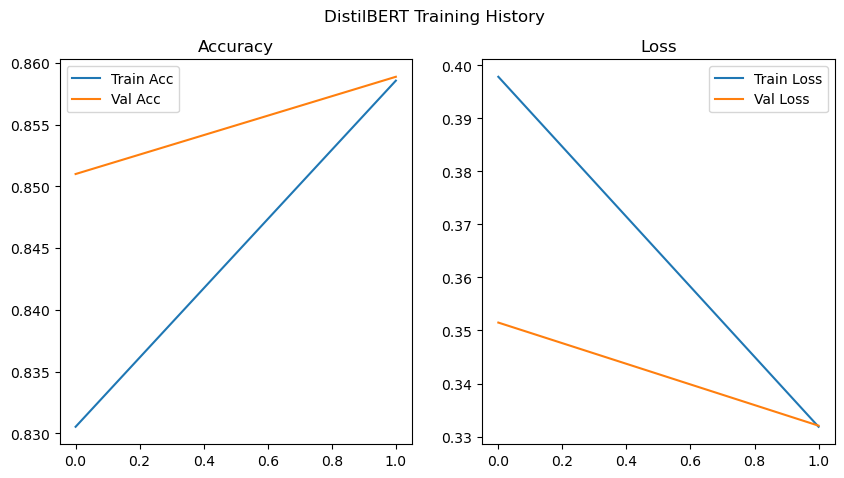

In [10]:
# 📈 11. TRAINING CURVES
def plot_training_curves(history, title="Training History"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.suptitle(title)
    plt.show()

plot_training_curves(history_bert, title="DistilBERT Training History")

# 7. Save the Model

In [16]:
import os
from datetime import datetime

# ✅ Define the base directory (make sure it exists or gets created)
save_dir = "/Users/p24p/imdb-sentiment-analysis/models"
os.makedirs(save_dir, exist_ok=True)  # Create it if it doesn't exist

# ✅ Define the full filepath with a timestamp and the correct `.keras` extension
bert_model_path = os.path.join(
    save_dir,
    f"distilbert_model_{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
)

# ✅ Save the Keras model
bert_model.save(bert_model_path)

print(f"✅ DistilBERT classifier model saved to: {bert_model_path}")


✅ DistilBERT classifier model saved to: /Users/p24p/imdb-sentiment-analysis/models/distilbert_model_20250614-092417.keras


# 8. Evaluate on Test Set

313/313 ━━━━━━━━━━━━━━━━━━━━ 247s 787ms/step


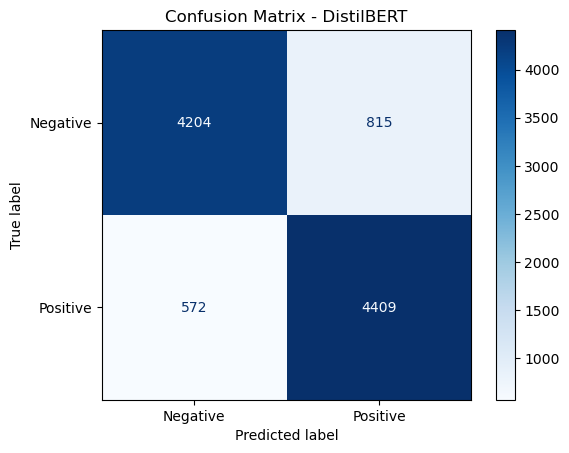


Classification Report (DistilBERT):
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      5019
           1       0.84      0.89      0.86      4981

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [13]:
# 🧠 13. EVALUATE DistilBERT
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_bert = (bert_model.predict({
    "input_ids": X_test_enc["input_ids"],
    "attention_mask": X_test_enc["attention_mask"]
}) > 0.5).astype(int).flatten()

cm_bert = confusion_matrix(y_test, y_pred_bert)
ConfusionMatrixDisplay(cm_bert, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
plt.title('Confusion Matrix - DistilBERT')
plt.show()

print("\nClassification Report (DistilBERT):\n", classification_report(y_test, y_pred_bert))